# Research Questions

In [1]:
# Import all libraries

import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
import dask
from matplotlib.colors import BoundaryNorm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import pandas as pd
import datetime
import shapely.geometry as sgeom
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
%matplotlib inline
from tabulate import tabulate

In [2]:
# Load the dataset

# Terrain file is for plotting purpose only
terrain_file = '../KHGX_Terrain_RangeMask.nc'


# Radar location
radar_lat = 29.4719
radar_lon = -95.0787

# Output figure directory
figdir = 'Figures'
os.makedirs(figdir, exist_ok=True)

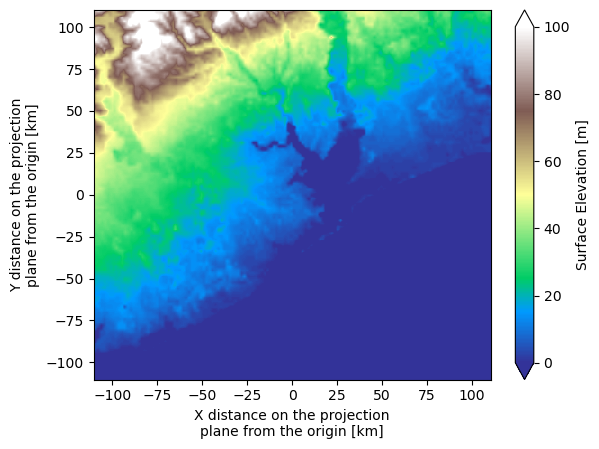

In [3]:
# Read topography file
terr = xr.open_dataset(terrain_file)
topoZ = terr['hgt']
topoLon = terr['x']
topoLat = terr['y']
topoZ.plot(vmin=0, vmax=100, cmap='terrain');

In [33]:
%store topoZ topoLon topoLat

Stored 'topoZ' (DataArray)
Stored 'topoLon' (DataArray)
Stored 'topoLat' (DataArray)


In [4]:
# Read cell tracking data

# Read and concatenate the stats files
def combine_nc_files(file_paths):
    datasets = [xr.open_dataset(path) for path in file_paths]
    combined = xr.concat(datasets, dim="tracks")
    return combined

file_paths = [
    "../data/stats/trackstats_20220601.0000_20220630.2359.nc",
    "../data/stats/trackstats_20220701.0000_20220731.2359.nc",
    "../data/stats/trackstats_20220801.0000_20220831.2359.nc",
]

stats = combine_nc_files(file_paths)


time_res = stats.attrs['time_resolution_hour']
pixel_radius = stats.attrs['pixel_radius_km']

# Get cell initial location
cell_lon0 = stats['cell_meanlon'].isel(times=0)
# Find tracks where initiation longitude is not NaN
# These tracks are problematic and should be excluded
ind = np.where(~np.isnan(cell_lon0))[0]

# Subset the tracks
stats = stats.isel(tracks=ind).load()
ntracks = stats.dims['tracks']
print(f'Number of valid tracks: {ntracks}')
stats
%store stats

c:\Users\omitu\anaconda3\envs\metstat\lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
c:\Users\omitu\anaconda3\envs\metstat\lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
c:\Users\omitu\anaconda3\envs\metstat\lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
c:\Users\omitu\anaconda3\envs\metstat\lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
c:\Users\omitu\anaconda3\envs\metstat\lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dat

Number of valid tracks: 21727
Stored 'stats' (Dataset)


In [5]:
stats

<xarray.Dataset>
Dimensions:                  (tracks: 21727, times: 100)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 11701 11702 11703 11704
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           (tracks) int32 7 3 18 15 2 9 6 2 ... 3 2 2 4 1 3 8
    base_time                (tracks, times) datetime64[ns] 2022-06-01T00:01:...
    meanlat                  (tracks, times) float32 28.89 28.9 ... nan nan
    meanlon                  (tracks, times) float32 -95.67 -95.68 ... nan nan
    area                     (tracks, times) float32 20.5 19.0 15.25 ... nan nan
    cloudnumber              (tracks, times) float64 1.0 4.0 6.0 ... nan nan nan
    ...                       ...
    start_split_tracknumber  (tracks) float64 nan nan nan ... 1.167e+04 nan nan
    start_split_timeindex    (tracks) float64 nan nan nan nan ... 16.0 nan nan
    start_split_cloudnumber  (tracks) float64 nan nan nan nan ... 1.0 nan nan
    end_merge_tracknumber    (tracks) float64 nan nan nan nan ... nan nan nan
    end_merge_timeindex      (tracks) float64 nan nan nan nan ... nan nan nan
    end_merge_cloudnumber    (tracks) float64 nan nan nan nan ... nan nan nan
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Mon Jul 10 21:16:26 2023
    startdate:             20220601.0000
    enddate:               20220630.2359
    timegap_hour:          0.25
    time_resolution_hour:  0.0833
    pixel_radius_km:       0.5

In [6]:
# Get cell statistics variables
tracks = stats['tracks']
times = stats['times']

lifetime = stats['track_duration'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
core_area = stats['core_area']
maxrange_flag = stats['maxrange_flag']

maxdbz = stats['max_dbz']
eth10 = stats['maxETH_10dbz']
eth20 = stats['maxETH_20dbz']
eth30 = stats['maxETH_30dbz']
eth40 = stats['maxETH_40dbz']
eth50 = stats['maxETH_50dbz']


In [7]:
%store cell_area cell_lon cell_lat

Stored 'cell_area' (DataArray)
Stored 'cell_lon' (DataArray)
Stored 'cell_lat' (DataArray)


In [8]:
cell_lon

<xarray.DataArray 'cell_meanlon' (tracks: 21727, times: 100)>
array([[-95.667534, -95.68225 , -95.699524, ...,        nan,        nan,
               nan],
       [-95.773224, -95.789085, -95.805084, ...,        nan,        nan,
               nan],
       [-95.59636 , -95.61903 , -95.63569 , ...,        nan,        nan,
               nan],
       ...,
       [-95.70304 ,        nan,        nan, ...,        nan,        nan,
               nan],
       [-96.152306, -96.15912 , -96.165   , ...,        nan,        nan,
               nan],
       [-94.01578 , -94.0261  , -94.03891 , ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * tracks   (tracks) int64 0 1 2 3 4 5 ... 11699 11700 11701 11702 11703 11704
  * times    (times) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Attributes:
    long_name:  Mean longitude of a convective cell
    units:      degrees_east

In [9]:
# Get track start/end hour
start_hour = start_time.dt.hour
end_hour = end_time.dt.hour

# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

end_maxrange_flag = np.ones(ntracks, dtype=float)
end_lon = np.full(ntracks, np.NaN, dtype=float)
end_lat = np.full(ntracks, np.NaN, dtype=float)

# Find tracks not end with merge or not start with split
nonmerge = np.where(np.isnan(end_merge_tracknumber))[0]
nonsplit = np.where(np.isnan(start_split_tracknumber))[0]
ntracks_nonmerge = len(nonmerge)
ntracks_nonsplit = len(nonsplit)
print(f'Number of non-merge tracks: {ntracks_nonmerge}')
print(f'Number of non-split tracks: {ntracks_nonsplit}')

nonsplit_in = np.where(np.isnan(start_split_tracknumber) & (start_maxrange_flag == 1))[0]
nonmerge_in = np.where(np.isnan(end_merge_tracknumber) & (end_maxrange_flag == 1))[0]
ntracks_nonsplit_in = len(nonsplit_in)
ntracks_nonmerge_in = len(nonmerge_in)
print(f'Number of non-split tracks within max range: {ntracks_nonsplit_in}')
print(f'Number of non-merge tracks within max range: {ntracks_nonmerge_in}')

merge = np.where(end_merge_tracknumber > 0)[0]
split = np.where(start_split_tracknumber > 0)[0]
ntracks_merge = len(merge)
ntracks_split = len(split)
print(f'Number of merge tracks: {ntracks_merge}')
print(f'Number of split tracks: {ntracks_split}')

Number of non-merge tracks: 17793
Number of non-split tracks: 17927
Number of non-split tracks within max range: 0
Number of non-merge tracks within max range: 17793
Number of merge tracks: 3934
Number of split tracks: 3800


In [31]:
%store nonsplit_in nonmerge_in split merge start_hour end_hour

Stored 'nonsplit_in' (ndarray)
Stored 'nonmerge_in' (ndarray)
Stored 'split' (ndarray)
Stored 'merge' (ndarray)
Stored 'start_hour' (DataArray)
Stored 'end_hour' (DataArray)


In [10]:
# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration = (lifetime.values / time_res).astype(int)
rangeflag = maxrange_flag.values
celllon = cell_lon.values
celllat = cell_lat.values

end_maxrange_flag = np.ones(ntracks, dtype=float)
end_lon = np.full(ntracks, np.NaN, dtype=float)
end_lat = np.full(ntracks, np.NaN, dtype=float)

# Get track last valid value
for ii in range(0, ntracks):
    # Get duration for the track
    iduration = duration[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag[ii,0:iduration]
    icell_lon = celllon[ii,0:iduration]
    icell_lat = celllat[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag[ii] = imaxrangeflag[-1]
    end_lon[ii] = icell_lon[-1]
    end_lat[ii] = icell_lat[-1]

In [27]:
%store start_lon start_lat end_lon end_lat

Stored 'start_lon' (DataArray)
Stored 'start_lat' (DataArray)
Stored 'end_lon' (ndarray)
Stored 'end_lat' (ndarray)


# 1. What are the characteristics of convective cells in terms of their core and total cell area?

### Desriptive analysis of the core area and cell area

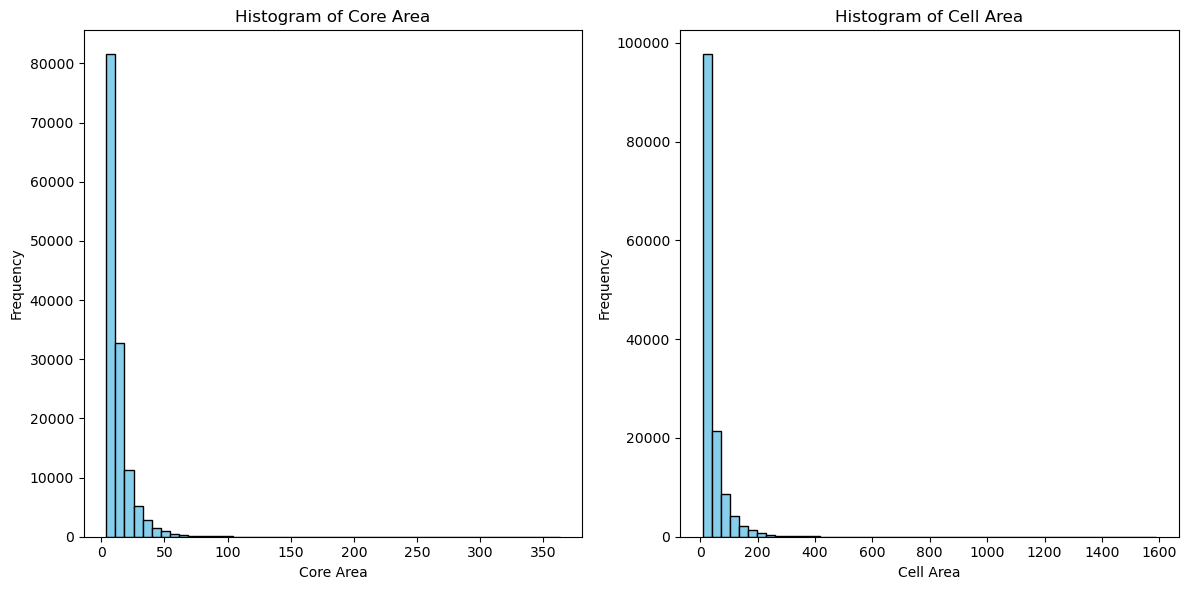

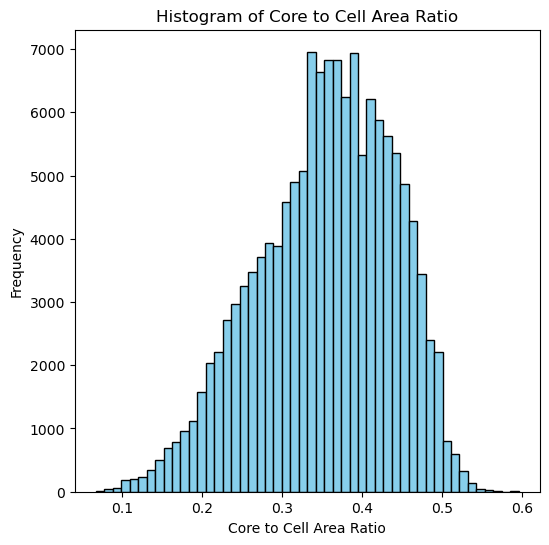

| Statistics       |        Value |
|:-----------------|-------------:|
| Core area median |    9.75      |
| Core area min    |    4         |
| Core area max    |  363         |
| Core area std    |   10.7984    |
| Cell area mean   |   40.9088    |
| Cell area median |   24.75      |
| Cell area min    |    8         |
| Cell area max    | 1588         |
| Cell area std    |   45.1893    |
| Ratio mean       |    0.354203  |
| Ratio median     |    0.360375  |
| Ratio min        |    0.0669145 |
| Ratio max        |    0.595745  |
| Ratio std        |    0.0840906 |


In [11]:
# Extract core and cell areas
core_area = stats['core_area']
cell_area = stats['cell_area']

# Compute basic statistics for core_area
core_area_mean = core_area.mean().item()
core_area_median = np.nanmedian(core_area)
core_area_min = np.nanmin(core_area)
core_area_max = np.nanmax(core_area)
core_area_std = np.nanstd(core_area)

# Compute basic statistics for cell_area
cell_area_mean = cell_area.mean().item()
cell_area_median = np.nanmedian(cell_area)
cell_area_min = np.nanmin(cell_area)
cell_area_max = np.nanmax(cell_area)
cell_area_std = np.nanstd(cell_area)

# Create histograms for core_area and cell_area
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(core_area.values.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Core Area')
plt.xlabel('Core Area')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(cell_area.values.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Cell Area')
plt.xlabel('Cell Area')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Compute ratio of core_area to cell_area and visualize its distribution
ratio = core_area / cell_area
ratio_mean = ratio.mean().item()
ratio_median = np.nanmedian(ratio)
ratio_min = np.nanmin(ratio)
ratio_max = np.nanmax(ratio)
ratio_std = np.nanstd(ratio)

plt.figure(figsize=(6, 6))
plt.hist(ratio.values.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Core to Cell Area Ratio')
plt.xlabel('Core to Cell Area Ratio')
plt.ylabel('Frequency')
plt.show()

# Prepare the data as a list of lists
data = [
    ["Core area median", core_area_median],
    ["Core area min", core_area_min],
    ["Core area max", core_area_max],
    ["Core area std", core_area_std],
    ["Cell area mean", cell_area_mean],
    ["Cell area median", cell_area_median],
    ["Cell area min", cell_area_min],
    ["Cell area max", cell_area_max],
    ["Cell area std", cell_area_std],
    ["Ratio mean", ratio_mean],
    ["Ratio median", ratio_median],
    ["Ratio min", ratio_min],
    ["Ratio max", ratio_max],
    ["Ratio std", ratio_std]
]

# Print the table
print(tabulate(data, headers=["Statistics", "Value"], tablefmt="pipe"))


Notes: 

Core Area: The mean core area is approximately 12.23, but the distribution is skewed towards larger values (the median is 9, less than the mean), as can be seen in the histogram. The smallest core area is 4, and the largest is 206.5. The standard deviation is 10.63, indicating a fair amount of variability in the core areas of the convective cells.

Cell Area: The mean cell area is approximately 38.90, and the distribution is also skewed towards larger values (the median is 23). The smallest cell area is 9.5, and the largest is 844.75. The standard deviation is 45.25, suggesting a high degree of variability in the cell areas.

Ratio of Core Area to Cell Area: On average, the core area makes up about 36% of the cell area. This ratio has a fairly tight distribution (standard deviation is 0.08), with most values falling between 7% and 58%.

These results provide a general understanding of the size and structure of the convective cells in the dataset. They show that there is a wide range of cell and core sizes, with the core typically occupying about a third of the total cell area.

### 1.1 How does the core area and cell area change over the lifespan of a convective cell? (Temporal analysis)

The maximum lifetime is 5.6644


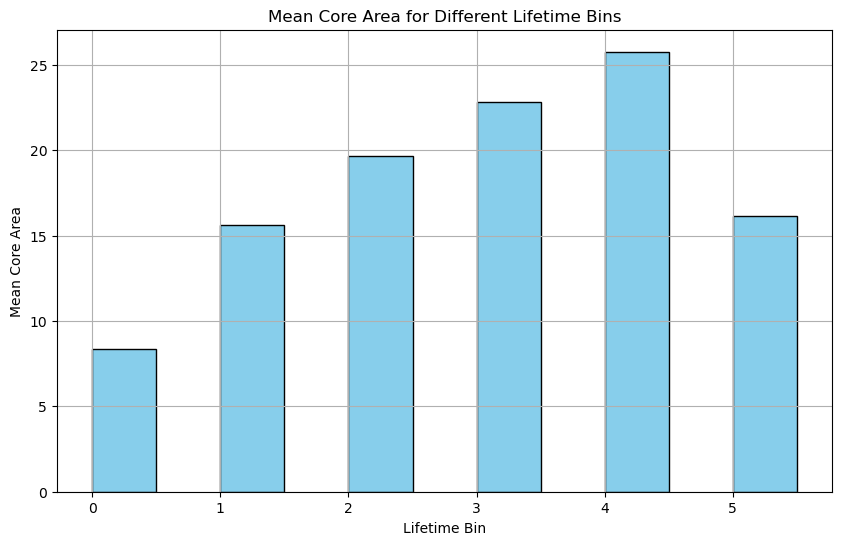

In [12]:
# Find the maximum lifetime
print(f'The maximum lifetime is {np.nanmax(lifetime.values)}')

# 
idx_long = np.where(lifetime > 0)[0]
lifetime_long = lifetime.isel(tracks=idx_long)          # Lifetime of cells greater than zero
core_area_long = core_area.isel(tracks=idx_long)        # Core area of the cells greater than zero

# Plot the core_area for each track over time
# Compute the mean core area across time for each track with lifetime > 0
core_area_mean_long = np.nanmean(core_area_long.values, axis=1)
# Bin lifetime into specified bins
bins = np.array([0, 1, 2, 3, 4, 5, 6])  # define the bins
lifetime_binned = np.digitize(lifetime_long.values, bins)  # bin the lifetime

# Calculate the mean core area for each bin
core_area_bin_means = []
for i in range(1, len(bins)):
    idx_bin = np.where(lifetime_binned == i)[0]
    core_area_bin_mean = np.nanmean(core_area_mean_long[idx_bin])
    core_area_bin_means.append(core_area_bin_mean)

# Create bar graph
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], core_area_bin_means, width=0.5, color='skyblue', edgecolor='black', align='edge')
plt.title('Mean Core Area for Different Lifetime Bins')
plt.xlabel('Lifetime Bin')
plt.ylabel('Mean Core Area')
plt.xticks(bins[:-1], labels=[f'{bins[i]}' for i in range(len(bins)-1)])
plt.grid(True)
plt.show()



In [13]:
idx_long_1 = np.where((lifetime > 0) & (lifetime < 1))[0]
lifetime_1 = lifetime.isel(tracks=idx_long_1)          # Lifetime of cells greater than zero
core_area_1 = core_area.isel(tracks=idx_long_1)        # Core area of the cells greater than zero
cell_area_1 = cell_area.isel(tracks=idx_long_1)

idx_long_2 = np.where((lifetime > 1) & (lifetime < 2))[0]
lifetime_2 = lifetime.isel(tracks=idx_long_2)          # Lifetime of cells greater than zero
core_area_2 = core_area.isel(tracks=idx_long_2)        # Core area of the cells greater than zero
cell_area_2 = cell_area.isel(tracks=idx_long_2)

idx_long_3 = np.where((lifetime > 2) & (lifetime < 3))[0]
lifetime_3 = lifetime.isel(tracks=idx_long_3)          # Lifetime of cells greater than zero
core_area_3 = core_area.isel(tracks=idx_long_3)        # Core area of the cells greater than zero
cell_area_3 = cell_area.isel(tracks=idx_long_3)

idx_long_4 = np.where((lifetime > 3) & (lifetime < 4))[0]
lifetime_4 = lifetime.isel(tracks=idx_long_4)          # Lifetime of cells greater than zero
core_area_4 = core_area.isel(tracks=idx_long_4)        # Core area of the cells greater than zero
cell_area_4 = cell_area.isel(tracks=idx_long_4)

idx_long_5 = np.where((lifetime > 4) & (lifetime < 5))[0]
lifetime_5 = lifetime.isel(tracks=idx_long_5)          # Lifetime of cells greater than zero
core_area_5 = core_area.isel(tracks=idx_long_5)        # Core area of the cells greater than zero
cell_area_5 = cell_area.isel(tracks=idx_long_5)

idx_long_6 = np.where((lifetime > 5) & (lifetime < 6))[0]
lifetime_6 = lifetime.isel(tracks=idx_long_6)          # Lifetime of cells greater than zero
core_area_6 = core_area.isel(tracks=idx_long_6)        # Core area of the cells greater than zero
cell_area_6 = cell_area.isel(tracks=idx_long_6)

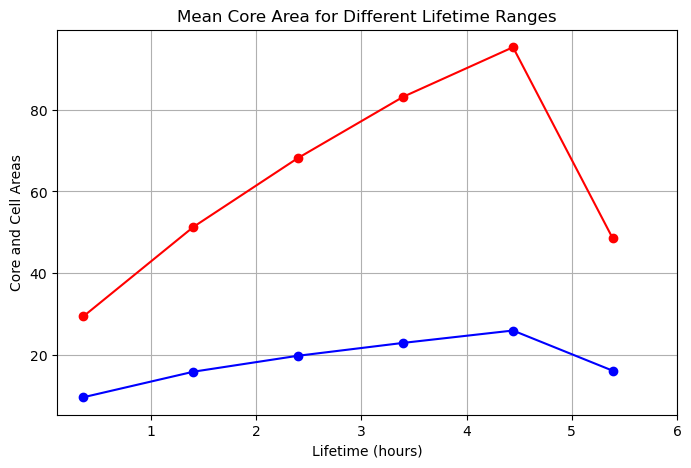

In [14]:
# Calculate mean core area for each lifetime range
mean_core_area_1 = np.nanmean(core_area_1)
mean_core_area_2 = np.nanmean(core_area_2)
mean_core_area_3 = np.nanmean(core_area_3)
mean_core_area_4 = np.nanmean(core_area_4)
mean_core_area_5 = np.nanmean(core_area_5)
mean_core_area_6 = np.nanmean(core_area_6)

mean_cell_area_1 = np.nanmean(cell_area_1)
mean_cell_area_2 = np.nanmean(cell_area_2)
mean_cell_area_3 = np.nanmean(cell_area_3)
mean_cell_area_4 = np.nanmean(cell_area_4)
mean_cell_area_5 = np.nanmean(cell_area_5)
mean_cell_area_6 = np.nanmean(cell_area_6)

mean_lifetime_1 = np.nanmean(lifetime_1)
mean_lifetime_2 = np.nanmean(lifetime_2)
mean_lifetime_3 = np.nanmean(lifetime_3)
mean_lifetime_4 = np.nanmean(lifetime_4)
mean_lifetime_5 = np.nanmean(lifetime_5)
mean_lifetime_6 = np.nanmean(lifetime_6)

# Create line chart for each lifetime range
plt.figure(figsize=(8, 5))
plt.plot([mean_lifetime_1, mean_lifetime_2, mean_lifetime_3, mean_lifetime_4, mean_lifetime_5, mean_lifetime_6], 
         [mean_core_area_1, mean_core_area_2, mean_core_area_3, mean_core_area_4, mean_core_area_5, mean_core_area_6], 
         marker='o', linestyle='-', color='blue', label = "Mean Core Area")
plt.plot([mean_lifetime_1, mean_lifetime_2, mean_lifetime_3, mean_lifetime_4, mean_lifetime_5, mean_lifetime_6], 
         [mean_cell_area_1, mean_cell_area_2, mean_cell_area_3, mean_cell_area_4, mean_cell_area_5, mean_cell_area_6], 
         marker='o', linestyle='-', color='red', label = "Mean Cell Area")
plt.title('Mean Core Area for Different Lifetime Ranges')
plt.xlabel('Lifetime (hours)')
plt.ylabel('Core and Cell Areas')
plt.xticks([1, 2, 3, 4, 5, 6])
plt.grid(True)
plt.show()


In [15]:
# Save the variables above
%store 

Stored variables and their in-db values:
cell_area                -> <xarray.DataArray 'cell_area' (tracks: 21727, time
cell_lat                 -> <xarray.DataArray 'cell_meanlat' (tracks: 21727, t
cell_lon                 -> <xarray.DataArray 'cell_meanlon' (tracks: 21727, t
core_area                -> <xarray.DataArray 'core_area' (tracks: 21727, time
core_meanlat             -> array([28.891169, 28.901718, 28.910925, ...,      
core_meanlon             -> array([-95.66735, -95.68225, -95.69984, ...,      
df                       ->           tracks  times  cell_area  core_area  lif
df_lifetime              ->         lifetime
tracks          
0         0.5831
name                     -> 'Femi'
number                   -> 2
stats                    -> <xarray.Dataset>
Dimensions:                  (tra


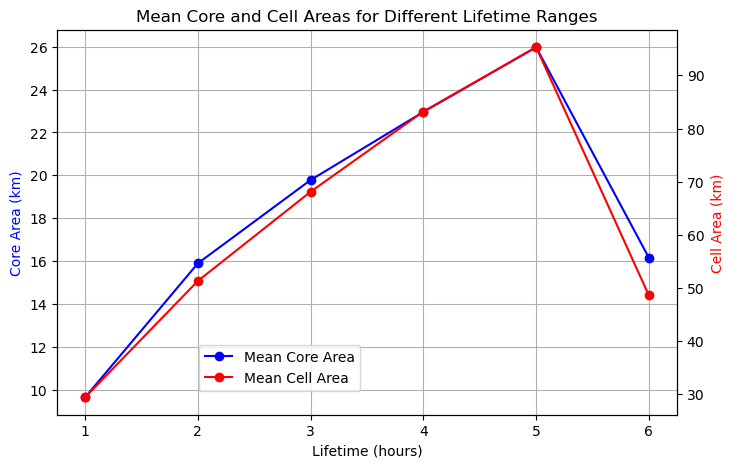

In [16]:
# Calculate mean cell area for each lifetime range
mean_cell_area_1 = np.nanmean(cell_area.isel(tracks=idx_long_1).values)
mean_cell_area_2 = np.nanmean(cell_area.isel(tracks=idx_long_2).values)
mean_cell_area_3 = np.nanmean(cell_area.isel(tracks=idx_long_3).values)
mean_cell_area_4 = np.nanmean(cell_area.isel(tracks=idx_long_4).values)
mean_cell_area_5 = np.nanmean(cell_area.isel(tracks=idx_long_5).values)
mean_cell_area_6 = np.nanmean(cell_area.isel(tracks=idx_long_6).values)

# Create figure and axis for left y-axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot mean core area on left y-axis
ax1.plot([1, 2, 3, 4, 5, 6], 
         [mean_core_area_1, mean_core_area_2, mean_core_area_3, mean_core_area_4, mean_core_area_5, mean_core_area_6], 
         marker='o', linestyle='-', color='blue', label='Mean Core Area')

# Create another axis for right y-axis, sharing the same x-axis
ax2 = ax1.twinx()

# Plot mean cell area on right y-axis
ax2.plot([1, 2, 3, 4, 5, 6], 
         [mean_cell_area_1, mean_cell_area_2, mean_cell_area_3, mean_cell_area_4, mean_cell_area_5, mean_cell_area_6], 
         marker='o', linestyle='-', color='red', label='Mean Cell Area')

# Set labels and title
ax1.set_xlabel('Lifetime (hours)')
ax1.set_ylabel('Core Area (km)', color='blue')
ax2.set_ylabel('Cell Area (km)', color='red')
plt.title('Mean Core and Cell Areas for Different Lifetime Ranges')
plt.xticks([1, 2, 3, 4, 5, 6])

# Display grid and legend
ax1.grid(True)
fig.legend(loc="upper right", bbox_to_anchor=(0.5,0.2), bbox_transform=ax1.transAxes)

# Show the plot
plt.show()


### 1.2 How do the core and cell areas change over the entire geographical location? (Spatial analysis). In addition, how does the ratio of core area to total cell area change over the life cycle of a convective cell?

In [17]:


# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration = (lifetime.values / time_res).astype(int)
rangeflag = maxrange_flag.values
celllon = cell_lon.values
celllat = cell_lat.values



# Get track last valid value
for ii in range(0, ntracks):
    # Get duration for the track
    iduration = duration[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag[ii,0:iduration]
    icell_lon = celllon[ii,0:iduration]
    icell_lat = celllat[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag[ii] = imaxrangeflag[-1]
    end_lon[ii] = icell_lon[-1]
    end_lat[ii] = icell_lat[-1]

In [18]:
# heatmaps (variable (e.g., cell area, lifetime) value in lon-lat bins)
lon_nbin = 17
lat_nbin = 16
lonbinsize = 0.14
latbinsize = 0.13

buffer = 0.05
minlon, maxlon = np.nanmin([start_lon.values, end_lon])-buffer, np.nanmax([start_lon.values, end_lon])+buffer
minlat, maxlat = np.nanmin([start_lat.values, end_lat])-buffer, np.nanmax([start_lat.values, end_lat])+buffer
print(minlon, maxlon, minlat, maxlat)

lonbins = np.arange(lon_nbin+1)*lonbinsize + minlon
latbins = np.arange(lat_nbin+1)*latbinsize + minlat - 0.05

# Count cell start/end location heatmap with the Cartesian grid
hist2d_startloc_02deg, yy, xx = np.histogram2d(start_lat, start_lon, bins=[latbins, lonbins])
hist2d_endloc_02deg, yy, xx = np.histogram2d(end_lat, end_lon, bins=[latbins, lonbins])

Mean_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH10_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH10_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH10_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH20_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH20_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH20_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH30_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH30_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH30_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
pt95_ETH30_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH40_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH40_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH40_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH50_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH50_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH50_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Samples_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_Core_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_Core_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_Core_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_Core_Cell_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_Core_Cell_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_Core_Cell_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

Lon_flat = np.array(cell_lon).flatten()
Lat_flat = np.array(cell_lat).flatten()
Area_flat = np.array(cell_area).flatten()
ETH10_flat = np.array(eth10).flatten()
ETH20_flat = np.array(eth20).flatten()
ETH30_flat = np.array(eth30).flatten()
ETH40_flat = np.array(eth40).flatten()
ETH50_flat = np.array(eth50).flatten()
Core_Area_flat = np.array(core_area).flatten()
Core_Cell_Area_flat = np.array(core_area/cell_area).flatten()

ETH30_gt7km_flat = np.array(eth30.where(eth30 > 7)).flatten()
Mean_ETH30_7km_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

min_nsample = 10

# Loop over each lat/lon bin
for i in np.arange(lon_nbin):
    for j in np.arange(lat_nbin):
        # Find all cells within the bin and have cell area > 0
        mask = np.logical_and(np.logical_and(np.logical_and(np.logical_and(Lon_flat >= lonbins[i], Lon_flat < lonbins[i]+lonbinsize),
                              Lat_flat >= latbins[j]), Lat_flat < latbins[j]+latbinsize), Area_flat > 0)
        # Record number of samples in the bin
        Samples_heatmap[j,i] = np.size(np.where(mask == True))
        # Compute statistics if number of samples > threshold
        if np.size(np.where(mask == True)) >= min_nsample:
            Mean_Area_heatmap[j,i] = np.nanmean(Area_flat[mask])
            Median_Area_heatmap[j,i] = np.nanmedian(Area_flat[mask])
            Max_Area_heatmap[j,i] = np.nanmax(Area_flat[mask])
            Mean_ETH10_heatmap[j,i] = np.nanmean(ETH10_flat[mask])
            Median_ETH10_heatmap[j,i] = np.nanmedian(ETH10_flat[mask])
            Max_ETH10_heatmap[j,i] = np.nanmax(ETH10_flat[mask])
            Mean_ETH20_heatmap[j,i] = np.nanmean(ETH20_flat[mask])
            Median_ETH20_heatmap[j,i] = np.nanmedian(ETH20_flat[mask])
            Max_ETH20_heatmap[j,i] = np.nanmax(ETH20_flat[mask])
            Mean_ETH30_heatmap[j,i] = np.nanmean(ETH30_flat[mask])
            Median_ETH30_heatmap[j,i] = np.nanmedian(ETH30_flat[mask])
            Max_ETH30_heatmap[j,i] = np.nanmax(ETH30_flat[mask])
            pt95_ETH30_heatmap[j,i] = np.nanpercentile(ETH30_flat[mask], 95)
            Mean_ETH30_7km_heatmap[j,i] = np.nanmean(ETH30_gt7km_flat[mask])
            Mean_Core_Area_heatmap[j,i] = np.nanmean(Core_Area_flat[mask])
            Median_Core_Area_heatmap[j,i] = np.nanmedian(Core_Area_flat[mask])
            Max_Core_Area_heatmap[j,i] = np.nanmax(Core_Area_flat[mask])
            Mean_Core_Cell_Area_heatmap[j,i] = np.nanmean(Core_Cell_Area_flat[mask])
            Median_Core_Cell_Area_heatmap[j,i] = np.nanmedian(Core_Cell_Area_flat[mask])
            Max_Core_Cell_Area_heatmap[j,i] = np.nanmax(Core_Cell_Area_flat[mask])
            
            Mean_ETH40_heatmap[j,i] = np.nanmean(ETH40_flat[mask])
            Median_ETH40_heatmap[j,i] = np.nanmedian(ETH40_flat[mask])
            Max_ETH40_heatmap[j,i] = np.nanmax(ETH40_flat[mask])
            Mean_ETH50_heatmap[j,i] = np.nanmean(ETH50_flat[mask])
            Median_ETH50_heatmap[j,i] = np.nanmedian(ETH50_flat[mask])
            Max_ETH50_heatmap[j,i] = np.nanmax(ETH50_flat[mask])

-96.26935272216797 -93.88798065185547 28.43370361328125 30.50552444458008


C:\Users\omitu\AppData\Local\Temp\ipykernel_9784\1590587368.py:96: RuntimeWarning: Mean of empty slice
  Mean_ETH50_heatmap[j,i] = np.nanmean(ETH50_flat[mask])
C:\Users\omitu\AppData\Local\Temp\ipykernel_9784\1590587368.py:97: RuntimeWarning: All-NaN slice encountered
  Median_ETH50_heatmap[j,i] = np.nanmedian(ETH50_flat[mask])
C:\Users\omitu\AppData\Local\Temp\ipykernel_9784\1590587368.py:98: RuntimeWarning: All-NaN slice encountered
  Max_ETH50_heatmap[j,i] = np.nanmax(ETH50_flat[mask])
C:\Users\omitu\AppData\Local\Temp\ipykernel_9784\1590587368.py:85: RuntimeWarning: Mean of empty slice
  Mean_ETH30_7km_heatmap[j,i] = np.nanmean(ETH30_gt7km_flat[mask])


In [19]:
def plot_4heatmaps(dataarr, lonarr, latarr, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, cblabels, cbticks, titles, xlabels, ylabels, figname, eSDC=None):
    mpl.rcParams['font.size'] = 13
    mpl.rcParams['font.family'] = 'Arial'
    fig, axes = plt.subplots(2, 2, figsize=(12.5,10), dpi=100)
    marker_style = dict(color='k', linestyle='none', marker='o', markersize=12, markerfacecolor='red')
    topo_levs = [500,1000,1500,2000,2500]

    for row in range(2):
        for col in range(2):
            ax = axes[row,col]
            Zm = np.ma.masked_where(dataarr[row][col] == 0, dataarr[row][col])
            cmap = plt.get_cmap(cmaps[row][col])
            norm = mpl.colors.BoundaryNorm(boundaries=levels[row][col], ncolors=cmap.N)
            p1 = ax.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap, shading='auto')
            cb = plt.colorbar(p1, ax=ax, label=cblabels[row][col], ticks=cbticks[row][col])
            ax.set_xlabel(xlabels[row][col])
            ax.set_ylabel(ylabels[row][col])
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlim(np.min(lonarr), np.max(lonarr))
            ax.set_ylim(np.min(latarr), np.max(latarr))
            ax.set_xticks(np.arange(-96.26659088134765, -93.88899536132813, 0.5))
            ax.set_yticks(np.arange(28.43370361328125, 30.50535469055176, 0.5))
            ax.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo[row][col], linewidths=1.5)
            #ax.plot(radar_lon, radar_lat, **marker_style)
            #ax.text(0.5, 1.05, 'AMF', fontsize=15)
            ax.grid(ls='--')
            if eSDC is not None:
                ax.axvline(x=eSDC, color='magenta', lw=2)

            # Legend for terrain
            custom_lines = [mpl.lines.Line2D([0], [0], color=plt.get_cmap(cmap_topo[row][col])(0.8), lw=2)]
            # ax.legend(custom_lines, ['Terrain'], loc='upper right')  # Add terrain legend

    fig.tight_layout()
    # fig.savefig(figname, bbox_inches='tight', facecolor='w', dpi=300)
    
    return fig

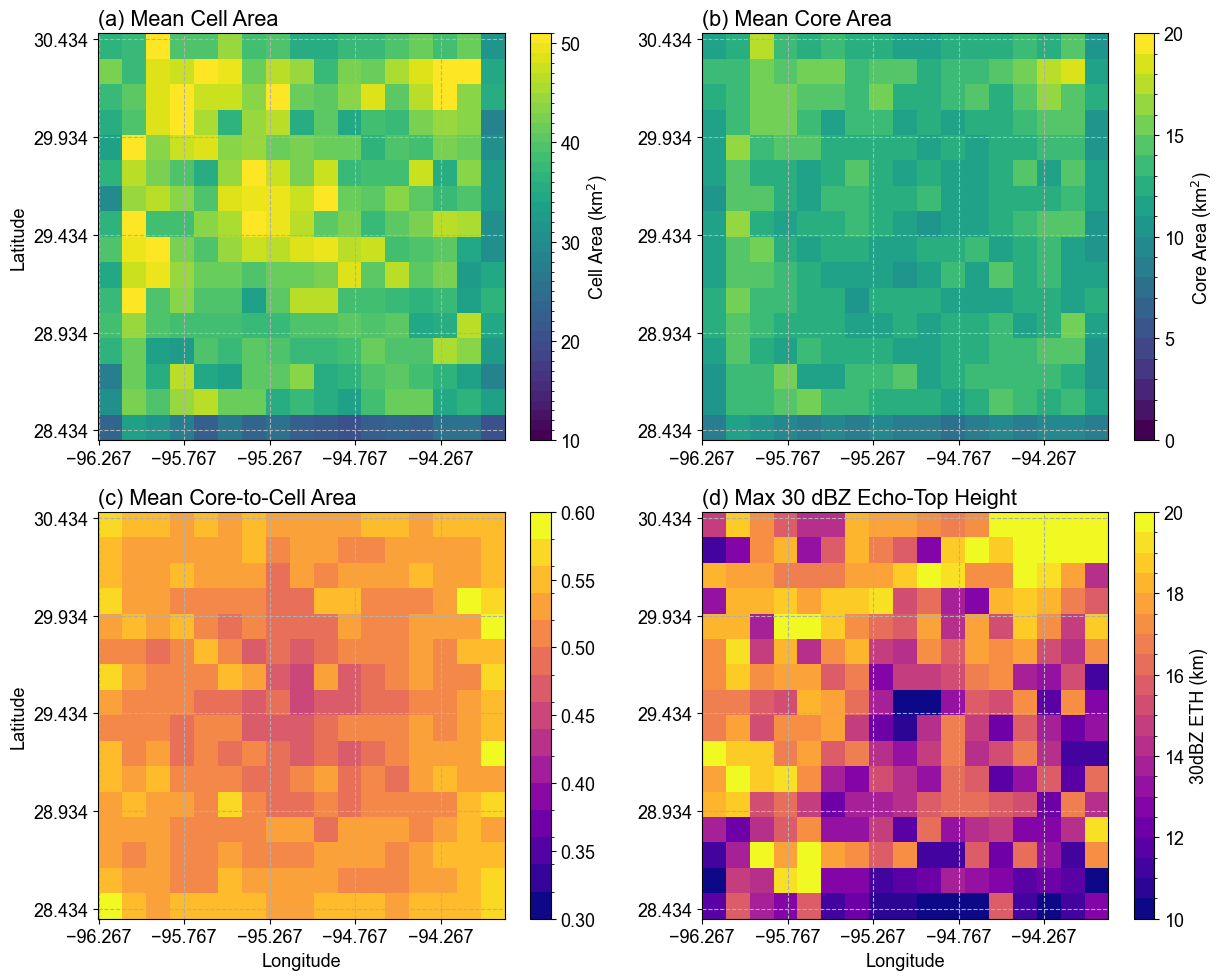

In [20]:
# Tip: For the second part, divide the core_area by the cell_area for each time step.

dataarr = [[Mean_Area_heatmap, Mean_Core_Area_heatmap], [Max_Core_Cell_Area_heatmap, Max_ETH30_heatmap]]
levels = [[np.arange(10, 51.1, 1), np.arange(0, 20.1, 1)], [np.arange(0.3, 0.61, 0.02), np.arange(10, 20.1, 0.5)]]
cbticks = [[np.arange(10, 51.1, 10), np.arange(0, 20.1, 5)], [np.arange(0.3, 0.61, 0.05), np.arange(10, 20.1, 2)]]
cmap = [['viridis', 'viridis'], ['plasma','plasma']]
cmap_topo = [['Reds', 'Reds'], ['Greens', 'Greens']]
titles = [['(a) Mean Cell Area', '(b) Mean Core Area'], 
          ['(c) Mean Core-to-Cell Area', '(d) Max 30 dBZ Echo-Top Height'],]
cblabels = [['Cell Area (km$^2$)', 'Core Area (km$^2$)'], ['', '30dBZ ETH (km)']]
xlabels = [['',''], ['Longitude','Longitude']]
ylabels = [['Latitude',''],['Latitude','']]
figname = f'{figdir}celltrack_StartEndloc_MeanCellArea_Max30dBZETH_0.2deg.png'
fig = plot_4heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, cblabels, cbticks, titles, xlabels, ylabels, figname)

### 1.4 Are there patterns in the core and total cell areas that correspond to the time of day or the time of year? For example, are larger core areas more common at certain times of day or in certain seasons?

In [21]:
# Get initiation and time
hour_bin = np.arange(0, 25, 1)
hist_starthour, bins = np.histogram(start_hour, bins=hour_bin, range=(0,24), density=False)
hist_starthour_in, bins = np.histogram(start_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

hist_endhour, bins = np.histogram(end_hour, bins=hour_bin, range=(0,24), density=False)
hist_endhour_in, bins = np.histogram(end_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

# Initiation E.SDC vs. W.SDC
lon_SDC = -95.0787
hist_starthour_eSDC, bins = np.histogram(start_hour.where(start_lon > lon_SDC, drop=True), bins=hour_bin, range=(0,24), density=False)
hist_starthour_wSDC, bins = np.histogram(start_hour.where(start_lon <= lon_SDC, drop=True), bins=hour_bin, range=(0,24), density=False)

# Convert to local time (UTC-3)
hist_starthour_LT = np.roll(hist_starthour, -3)
hist_starthour_in_LT = np.roll(hist_starthour_in, -3)

hist_endhour_LT = np.roll(hist_endhour, -3)
hist_endhour_in_LT = np.roll(hist_endhour_in, -3)

hist_starthour_eSDC_LT = np.roll(hist_starthour_eSDC, -3)
hist_starthour_wSDC_LT = np.roll(hist_starthour_wSDC, -3)

# Fraction of E.SDC tracks to all tracks
hist_starthour_eSDC_LT_frac = 100 * (hist_starthour_eSDC_LT / hist_starthour_LT)

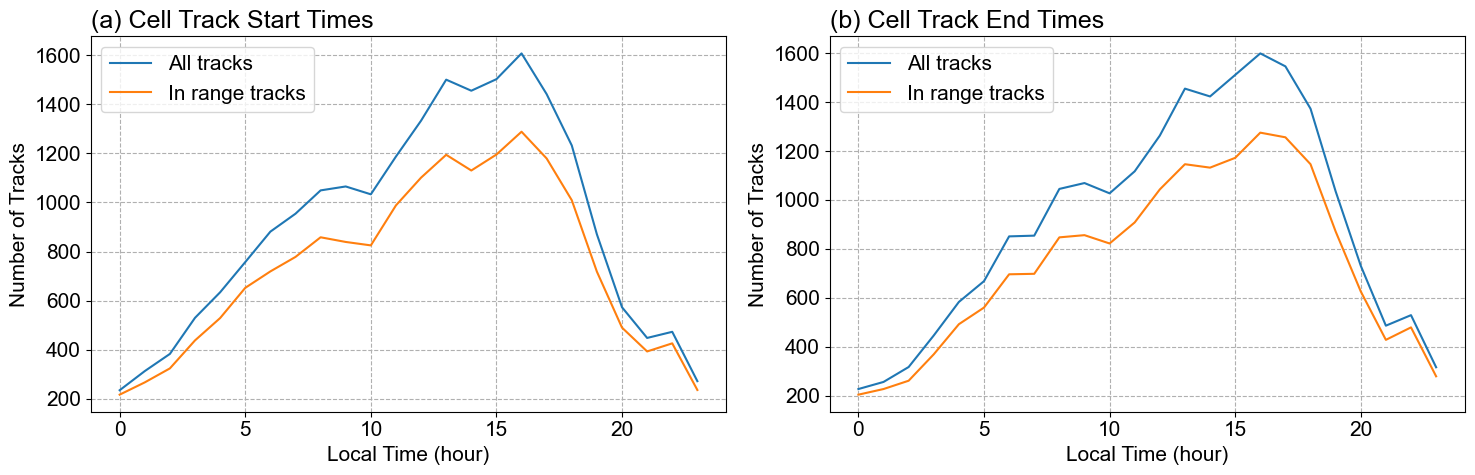

In [22]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Arial'
fig, axes = plt.subplots(1, 2, figsize=[15,5], dpi=100)

ax1 = axes[0]
ax1.plot(hour_bin[:-1], hist_starthour_LT, label='All tracks')
ax1.plot(hour_bin[:-1], hist_starthour_in_LT, label='In range tracks')
ax1.legend()
ax1.grid(ls='--')
ax1.set_title('(a) Cell Track Start Times', loc='left')
ax1.set_ylabel('Number of Tracks')
ax1.set_xlabel('Local Time (hour)')
#ax1.set_ylim(100, 420)

ax2 = axes[1]
ax2.plot(hour_bin[:-1], hist_endhour_LT, label='All tracks')
ax2.plot(hour_bin[:-1], hist_endhour_in_LT, label='In range tracks')
ax2.legend()
ax2.grid(ls='--')
ax2.set_title('(b) Cell Track End Times', loc='left')
ax2.set_ylabel('Number of Tracks')
ax2.set_xlabel('Local Time (hour)')
#ax2.set_ylim(100, 420)

fig.tight_layout()

# 2. Do convective cells exhibit homogeneous and consistently stronger updrafts?

### Here, we explore the variability in updraft intensity within convective cells of different sizes. Determine if larger convective cells tend to have consistently stronger updrafts throughout their core area or if there is significant spatial variability in updraft intensity.

In [23]:
# Calculate the quartiles of the 'cell_area' data
q25 = cell_area.quantile(0.25).values
q50 = cell_area.quantile(0.50).values
q75 = cell_area.quantile(0.75).values

# Create masks that select the indices where 'cell_area' falls into the specific quartile ranges
mask_q1 = cell_area <= q25
mask_q2 = (cell_area > q25) & (cell_area <= q50)
mask_q3 = (cell_area > q50) & (cell_area <= q75)
mask_q4 = cell_area > q75

# Select the values from 'core_area' at these indices
core_area_q1 = core_area.where(mask_q1, drop=True)
core_area_q2 = core_area.where(mask_q2, drop=True)
core_area_q3 = core_area.where(mask_q3, drop=True)
core_area_q4 = core_area.where(mask_q4, drop=True)

cell_lon_q1 = cell_lon.where(mask_q1, drop=True)
cell_lat_q1 = cell_lat.where(mask_q1, drop=True)
cell_lon_q2 = cell_lon.where(mask_q2, drop=True)
cell_lat_q2 = cell_lat.where(mask_q2, drop=True)
cell_lon_q3 = cell_lon.where(mask_q3, drop=True)
cell_lat_q3 = cell_lat.where(mask_q3, drop=True)
cell_lon_q4 = cell_lon.where(mask_q4, drop=True)
cell_lat_q4 = cell_lat.where(mask_q4, drop=True)


In [24]:
# heatmaps (variable (e.g., cell area, lifetime) value in lon-lat bins)
lon_nbin = 17
lat_nbin = 16
lonbinsize = 0.14
latbinsize = 0.13

lonbins = np.arange(lon_nbin+1)*lonbinsize + minlon
latbins = np.arange(lat_nbin+1)*latbinsize + minlat - 0.05

# Count cell start/end location heatmap with the Cartesian grid
Mean_Core_Area_heatmap_q1 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_Core_Area_heatmap_q1 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_Core_Area_heatmap_q1 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

Lon_flat_q1 = np.array(cell_lon_q1).flatten()
Lat_flat_q1 = np.array(cell_lat_q1).flatten()
Core_Area_flat_q1 = np.array(core_area_q1).flatten()

ETH30_gt7km_flat = np.array(eth30.where(eth30 > 7)).flatten()
Mean_ETH30_7km_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

min_nsample = 10

# Loop over each lat/lon bin
for i in np.arange(lon_nbin):
    for j in np.arange(lat_nbin):
        # Find all cells within the bin and have cell area > 0
        mask = np.logical_and(np.logical_and(np.logical_and(np.logical_and(Lon_flat_q1 >= lonbins[i], Lon_flat_q1 < lonbins[i]+lonbinsize),
                              Lat_flat_q1 >= latbins[j]), Lat_flat_q1 < latbins[j]+latbinsize), Core_Area_flat_q1 > 0)
        # Record number of samples in the bin
        Samples_heatmap[j,i] = np.size(np.where(mask == True))
        # Compute statistics if number of samples > threshold
        if np.size(np.where(mask == True)) >= min_nsample:
            Mean_Core_Area_heatmap_q1[j,i] = np.nanmean(Core_Area_flat_q1[mask])
            Median_Core_Area_heatmap_q1[j,i] = np.nanmedian(Core_Area_flat_q1[mask])
            Max_Core_Area_heatmap_q1[j,i] = np.nanmax(Core_Area_flat_q1[mask])
            

# heatmaps (variable (e.g., cell area, lifetime) value in lon-lat bins)
lon_nbin = 17
lat_nbin = 16
lonbinsize = 0.14
latbinsize = 0.13

lonbins = np.arange(lon_nbin+1)*lonbinsize + minlon
latbins = np.arange(lat_nbin+1)*latbinsize + minlat - 0.05

# Count cell start/end location heatmap with the Cartesian grid
Mean_Core_Area_heatmap_q2 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_Core_Area_heatmap_q2 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_Core_Area_heatmap_q2 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

Lon_flat_q2 = np.array(cell_lon_q2).flatten()
Lat_flat_q2 = np.array(cell_lat_q2).flatten()
Core_Area_flat_q2 = np.array(core_area_q2).flatten()

ETH30_gt7km_flat = np.array(eth30.where(eth30 > 7)).flatten()
Mean_ETH30_7km_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

min_nsample = 10

# Loop over each lat/lon bin
for i in np.arange(lon_nbin):
    for j in np.arange(lat_nbin):
        # Find all cells within the bin and have cell area > 0
        mask = np.logical_and(np.logical_and(np.logical_and(np.logical_and(Lon_flat_q2 >= lonbins[i], Lon_flat_q2 < lonbins[i]+lonbinsize),
                              Lat_flat_q2 >= latbins[j]), Lat_flat_q2 < latbins[j]+latbinsize), Core_Area_flat_q2 > 0)
        # Record number of samples in the bin
        Samples_heatmap[j,i] = np.size(np.where(mask == True))
        # Compute statistics if number of samples > threshold
        if np.size(np.where(mask == True)) >= min_nsample:
            Mean_Core_Area_heatmap_q2[j,i] = np.nanmean(Core_Area_flat_q2[mask])
            Median_Core_Area_heatmap_q2[j,i] = np.nanmedian(Core_Area_flat_q2[mask])
            Max_Core_Area_heatmap_q2[j,i] = np.nanmax(Core_Area_flat_q2[mask])

# heatmaps (variable (e.g., cell area, lifetime) value in lon-lat bins)
lon_nbin = 17
lat_nbin = 16
lonbinsize = 0.14
latbinsize = 0.13

lonbins = np.arange(lon_nbin+1)*lonbinsize + minlon
latbins = np.arange(lat_nbin+1)*latbinsize + minlat - 0.05

# Count cell start/end location heatmap with the Cartesian grid
Mean_Core_Area_heatmap_q3 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_Core_Area_heatmap_q3 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_Core_Area_heatmap_q3 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

Lon_flat_q3 = np.array(cell_lon_q3).flatten()
Lat_flat_q3 = np.array(cell_lat_q3).flatten()
Core_Area_flat_q3 = np.array(core_area_q3).flatten()

ETH30_gt7km_flat = np.array(eth30.where(eth30 > 7)).flatten()
Mean_ETH30_7km_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

min_nsample = 10

# Loop over each lat/lon bin
for i in np.arange(lon_nbin):
    for j in np.arange(lat_nbin):
        # Find all cells within the bin and have cell area > 0
        mask = np.logical_and(np.logical_and(np.logical_and(np.logical_and(Lon_flat_q3 >= lonbins[i], Lon_flat_q3 < lonbins[i]+lonbinsize),
                              Lat_flat_q3 >= latbins[j]), Lat_flat_q3 < latbins[j]+latbinsize), Core_Area_flat_q3 > 0)
        # Record number of samples in the bin
        Samples_heatmap[j,i] = np.size(np.where(mask == True))
        # Compute statistics if number of samples > threshold
        if np.size(np.where(mask == True)) >= min_nsample:
            Mean_Core_Area_heatmap_q3[j,i] = np.nanmean(Core_Area_flat_q3[mask])
            Median_Core_Area_heatmap_q3[j,i] = np.nanmedian(Core_Area_flat_q3[mask])
            Max_Core_Area_heatmap_q3[j,i] = np.nanmax(Core_Area_flat_q3[mask])
            
# heatmaps (variable (e.g., cell area, lifetime) value in lon-lat bins)
lon_nbin = 17
lat_nbin = 16
lonbinsize = 0.14
latbinsize = 0.13

lonbins = np.arange(lon_nbin+1)*lonbinsize + minlon
latbins = np.arange(lat_nbin+1)*latbinsize + minlat - 0.05

# Count cell start/end location heatmap with the Cartesian grid
Mean_Core_Area_heatmap_q4 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_Core_Area_heatmap_q4 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_Core_Area_heatmap_q4 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

Lon_flat_q4 = np.array(cell_lon_q4).flatten()
Lat_flat_q4 = np.array(cell_lat_q4).flatten()
Core_Area_flat_q4 = np.array(core_area_q4).flatten()

ETH30_gt7km_flat = np.array(eth30.where(eth30 > 7)).flatten()
Mean_ETH30_7km_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

min_nsample = 10

# Loop over each lat/lon bin
for i in np.arange(lon_nbin):
    for j in np.arange(lat_nbin):
        # Find all cells within the bin and have cell area > 0
        mask = np.logical_and(np.logical_and(np.logical_and(np.logical_and(Lon_flat_q4 >= lonbins[i], Lon_flat_q4 < lonbins[i]+lonbinsize),
                              Lat_flat_q4 >= latbins[j]), Lat_flat_q4 < latbins[j]+latbinsize), Core_Area_flat_q4 > 0)
        # Record number of samples in the bin
        Samples_heatmap[j,i] = np.size(np.where(mask == True))
        # Compute statistics if number of samples > threshold
        if np.size(np.where(mask == True)) >= min_nsample:
            Mean_Core_Area_heatmap_q4[j,i] = np.nanmean(Core_Area_flat_q4[mask])
            Median_Core_Area_heatmap_q4[j,i] = np.nanmedian(Core_Area_flat_q4[mask])
            Max_Core_Area_heatmap_q4[j,i] = np.nanmax(Core_Area_flat_q4[mask])
                           

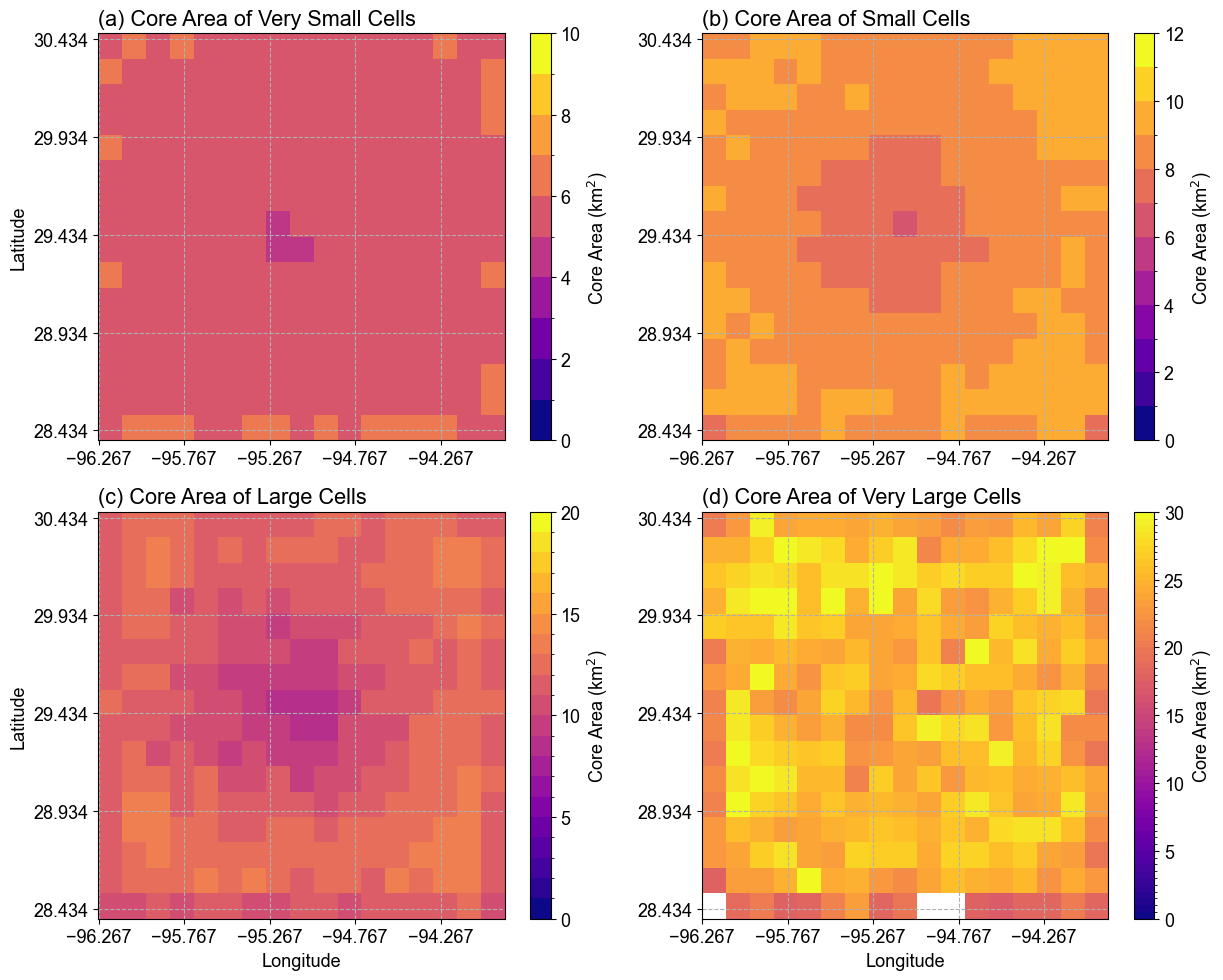

In [25]:
dataarr = [[Mean_Core_Area_heatmap_q1, Mean_Core_Area_heatmap_q2], [Mean_Core_Area_heatmap_q3, Mean_Core_Area_heatmap_q4]]
levels = [[np.arange(0, 10.1, 1), np.arange(0, 12.1, 1)], [np.arange(0, 20.1, 1), np.arange(0, 30.1, 0.5)]]
cbticks = [[np.arange(0, 10.1, 2), np.arange(0, 15.1, 2)], [np.arange(0, 20.1, 5), np.arange(0, 30.1, 5)]]
cmap = [['plasma', 'plasma'], ['plasma','plasma']]
cmap_topo = [['Reds', 'Reds'], ['Greens', 'Greens']]
titles = [['(a) Core Area of Very Small Cells', '(b) Core Area of Small Cells'], 
          ['(c) Core Area of Large Cells', '(d) Core Area of Very Large Cells'],]
cblabels = [['Core Area (km$^2$)', 'Core Area (km$^2$)'], ['Core Area (km$^2$)', 'Core Area (km$^2$)']]
xlabels = [['',''], ['Longitude','Longitude']]
ylabels = [['Latitude',''],['Latitude','']]
figname = f'{figdir}celltrack_StartEndloc_MeanCellArea_Max30dBZETH_0.2deg.png'

fig = plot_4heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, cblabels, cbticks, titles, xlabels, ylabels, figname)

### 2.1. Does the relationship between cell size and updraft intensity change over time? For example, do larger cells tend to have stronger updrafts at certain stages of their lifecycle?

NameError: name 'palette' is not defined

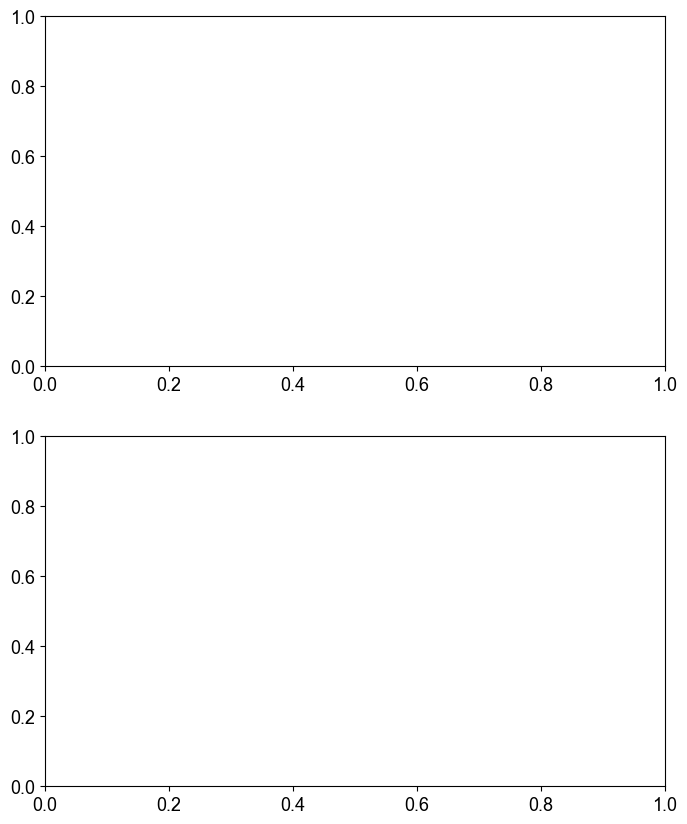

In [26]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Load the data
data = stats

# Extract relevant variables
cell_area = data['cell_area']
core_area = data['core_area']
track_duration = data['track_duration']

# Calculate lifetime using track_duration and time_resolution_hour
time_resolution_hour = data.attrs['time_resolution_hour']
lifetime = track_duration * time_resolution_hour

# Convert the xarray data to pandas DataFrame for easier manipulation
df_cell_area = cell_area.to_dataframe(name='cell_area').reset_index()
df_core_area = core_area.to_dataframe(name='core_area').reset_index()
df_lifetime = lifetime.to_dataframe(name='lifetime')

# Merge the dataframes
df = pd.merge(df_cell_area, df_core_area, on=['tracks', 'times'])
df = pd.merge(df, df_lifetime, on='tracks')

# Calculate quartiles for cell_area
df['cell_area_quartiles'] = pd.qcut(df['cell_area'], 4, labels=['Very Small Cells', 'Small Cells', 'Large Cells', 'Very Large Cells'])

# Define lifetime bins
bins = [0, 1, 2, 3, 4, 5, 6]

# Categorize lifetime into bins
df['lifetime_bin'] = pd.cut(df['lifetime'], bins=bins, include_lowest=True)

# Calculate the mean core_area for each lifetime bin and cell_area quartile
df_grouped = df.groupby(['cell_area_quartiles', 'lifetime_bin'])['core_area'].mean().reset_index()

# Convert lifetime_bin to its mid-points
df_grouped['lifetime_mid'] = df_grouped['lifetime_bin'].apply(lambda x: x.mid)

# Initialize a MinMaxScaler
scaler = MinMaxScaler()

# Normalize core_area within each cell_area quartile
df_grouped['core_area_normalized'] = df_grouped.groupby('cell_area_quartiles')['core_area'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).ravel())




# Create a subplot with 2 rows and 1 column
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Plot the non-normalized data
ax0 = sns.lineplot(ax=axes[0], data=df_grouped, x='lifetime_mid', y='core_area', hue='cell_area_quartiles', palette=palette, marker='o')
ax0.set_title('Non-normalized Mean Core Area Over Lifetime for Each Cell Area Quartile')
ax0.set_xlabel('Lifetime (hours)')
ax0.set_ylabel('Mean Core Area (km^2)')
ax0.grid(True)
ax0.legend(title='')

# Plot the normalized data
ax1 = sns.lineplot(ax=axes[1], data=df_grouped, x='lifetime_mid', y='core_area_normalized', hue='cell_area_quartiles', palette=palette, marker='o')
ax1.set_title('Normalized Mean Core Area Over Lifetime for Each Cell Area Quartile')
ax1.set_xlabel('Lifetime (hours)')
ax1.set_ylabel('Normalized Mean Core Area')
ax1.grid(True)
ax1.legend(title='')

# Adjust the layout
plt.tight_layout()
plt.show()



In [ ]:
df 

,tracks,times,cell_area,core_area
0,0,0,20.50,9.00
1,0,0,20.50,11.25
2,0,0,20.50,4.75
3,0,0,32.25,9.00
4,0,0,32.25,11.25
...,...,...,...,...
4898295,11704,95,NaN,NaN
4898296,11704,96,NaN,NaN
4898297,11704,97,NaN,NaN
4898298,11704,98,NaN,NaN


### 2.2 How do the core and total cell areas respond to variations in environmental conditions? For instance, are larger core areas associated with certain atmospheric conditions?

### 2.3 Now we find the spatial relationship between updraft intensity and precipitation using spatial correlation

In [ ]:
core_area_flatten = core_area.values.flatten()
core_meanlon = stats.core_meanlon.values.flatten()
core_meanlat = stats.core_meanlat.values.flatten()

# Create a DataFrame with lon, lat, and precip values
data = {'Longitude': core_meanlon, 'Latitude': core_meanlat, 'Core Area': core_area_flatten}
df = pd.DataFrame(data)

# Filter the DataFrame to include only rows where the 'Core Area' is not NaN
filtered_df = df[df['Core Area'].notna()]

# Save the filtered DataFrame to a CSV file
filtered_df.to_csv('./data/core_area_1.csv', index=False)

# Display the filtered DataFrame
print(filtered_df)


OSError: Cannot save file into a non-existent directory: 'data'

In [ ]:
# Subset only the non-zero precip values and concatenate them

import pandas as pd

# Read the three precipitation files
file1 = pd.read_csv('total_precip_summer_first.csv')
file2 = pd.read_csv('total_precip_summer_second.csv')
file3 = pd.read_csv('total_precip_summer_third.csv')

# Subset only the non-zero precipitation values
file1_nonzero = file1[file1['Precipitation'] != 0]
file2_nonzero = file2[file2['Precipitation'] != 0]
file3_nonzero = file3[file3['Precipitation'] != 0]

# Concatenate the non-zero precipitation values vertically
concatenated_data = pd.concat([file1_nonzero, file2_nonzero, file3_nonzero])

# Select only the desired columns
final_output = concatenated_data[['Longitude', 'Latitude', 'Precipitation']]

# Print the final output
final_output.to_csv('./data/final_output_1.csv', index=False)

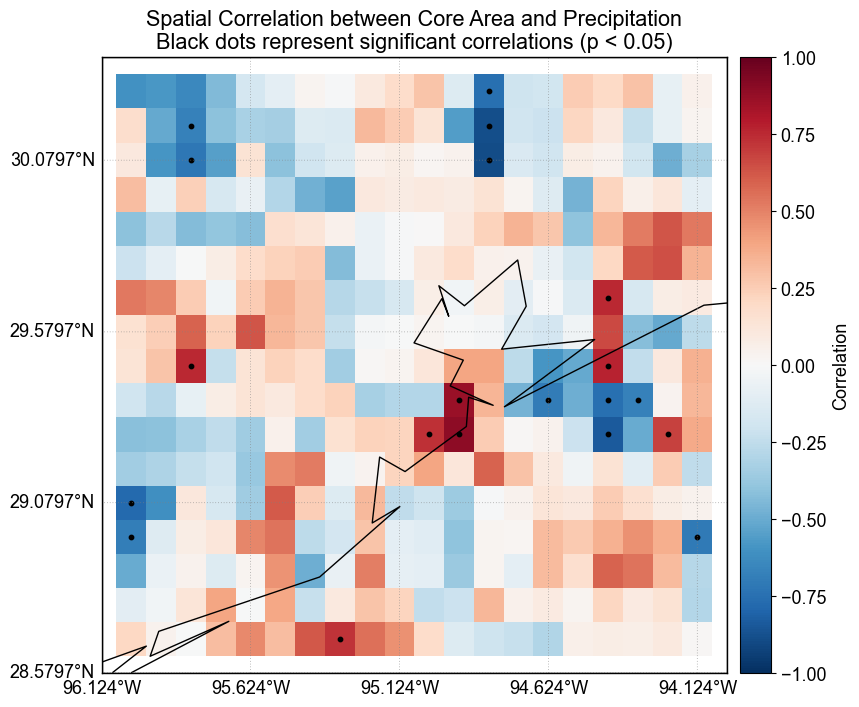

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

def calculate_local_correlations_and_pvalues(array1, array2, window_size):
    correlations = np.full(array1.shape, np.nan)
    p_values = np.full(array1.shape, np.nan)

    for i in range(window_size // 2, array1.shape[0] - window_size // 2):
        for j in range(window_size // 2, array1.shape[1] - window_size // 2):
            window1 = array1[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1]
            window2 = array2[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1]

            if not np.isnan(window1).any() and not np.isnan(window2).any():
                correlation, p_value = pearsonr(window1.flatten(), window2.flatten())
                correlations[i, j] = correlation
                p_values[i, j] = p_value

    return correlations, p_values

def plot_data(correlations, significant, min_lon, max_lon, min_lat, max_lat, grid_lons, grid_lats):
    m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='l')

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)

    x, y = m(grid_lons, grid_lats)

    masked_correlations = np.ma.array(correlations, mask=np.isnan(correlations))
    im = m.pcolormesh(x, y, masked_correlations, cmap='RdBu_r', vmin=-1, vmax=1, shading='auto')

    m.drawmapboundary()
    m.drawcoastlines()

    cbar = m.colorbar(im, location='right', pad='2%')
    cbar.set_label('Correlation')

    parallels = m.drawparallels(np.arange(min_lat, max_lat, 0.5), labels=[1, 0, 0, 0], color='gray', dashes=[1, 3], linewidth=0.5)
    meridians = m.drawmeridians(np.arange(min_lon, max_lon, 0.5), labels=[0, 0, 0, 1], color='gray', dashes=[1, 3], linewidth=0.5)

    x_sig, y_sig = m(grid_lons[significant], grid_lats[significant])
    m.scatter(x_sig, y_sig, color='black', s=10)

    plt.title('Spatial Correlation between Core Area and Precipitation\nBlack dots represent significant correlations (p < 0.05)')

    plt.show()

# Load data
core_area = pd.read_csv('./data/core_area_1.csv')
grouped_precip = pd.read_csv('./data/final_output_1.csv')

var1_lons = core_area["Longitude"]
var1_lats = core_area["Latitude"]
var1_data = core_area["Core Area"]

var2_lons = grouped_precip["Longitude"]
var2_lats = grouped_precip["Latitude"]
var2_data = grouped_precip["Precipitation"]

valid_indices = np.logical_and(~np.isnan(var1_data), ~np.isnan(var2_data))

var1_lons_valid = var1_lons[valid_indices]
var1_lats_valid = var1_lats[valid_indices]
var1_data_valid = var1_data[valid_indices]

var2_lons_valid = var2_lons[valid_indices]
var2_lats_valid = var2_lats[valid_indices]
var2_data_valid = var2_data[valid_indices]

grid_resolution = 0.1
grid_lons = np.arange(min(var1_lons_valid), max(var1_lons_valid), grid_resolution)
grid_lats = np.arange(min(var1_lats_valid), max(var1_lats_valid), grid_resolution)
grid_lons, grid_lats = np.meshgrid(grid_lons, grid_lats)

var1_interp = griddata((var1_lons_valid, var1_lats_valid), var1_data_valid, (grid_lons, grid_lats), method='cubic')
var2_interp = griddata((var2_lons_valid, var2_lats_valid), var2_data_valid, (grid_lons, grid_lats), method='cubic')

window_size = 3

correlations, p_values = calculate_local_correlations_and_pvalues(var1_interp, var2_interp, window_size)

significant = p_values < 0.05

min_lon_data = np.nanmin(grid_lons[~np.isnan(var1_interp)])
max_lon_data = np.nanmax(grid_lons[~np.isnan(var1_interp)])
min_lat_data = np.nanmin(grid_lats[~np.isnan(var1_interp)])
max_lat_data = np.nanmax(grid_lats[~np.isnan(var1_interp)])

plot_data(correlations, significant, min_lon_data, max_lon_data, min_lat_data, max_lat_data, grid_lons, grid_lats)


## Next steps:

In [ ]:
# Understand why there are areas of low precipitation. 
# Find out those LCZ areas, and see if the low correlation values are as a result of LCZ or climate.
# If it is a result of LCZ, find out whether which LCZ leads to high precip or low precip.
# Also find out if the LCZ t one location can impact that at another location.
# FInd out how LCZ affects updraft and precipitation.

# If the changes are due to climate processes, carry out other analyses.

### 2.3.1 Are larger core and cell areas associated with increased rainfall rates or more intense precipitation? If so, how accurately can these areas be used to predict rainfall amounts?

In [2]:
import os
import geopandas as gpd

In [5]:
# Path to the latest provided zipped folder
latest_zip_path = "C:/Users/omitu/Desktop/drive-download-20230919T032011Z-001/"
latest_extract_path = "C:/Users/omitu/Desktop/drive-download-20230919T032011Z-001/"

# Extract the zipped contents
#with zipfile.ZipFile(latest_zip_path, 'r') as zip_ref:
#    zip_ref.extractall(latest_extract_path)

# Identify the shapefile within the extracted contents
latest_shp_file = [file for file in os.listdir(latest_extract_path) if file.endswith('.shp')][0]

# Load the shapefile into a GeoDataFrame
latest_shapefile = gpd.read_file(os.path.join(latest_extract_path, latest_shp_file))

# Display the first few rows of the GeoDataFrame
latest_shapefile.head()


,landcover,count,geometry
0,2,8,"POLYGON ((-93.92156 29.68213, -93.92156 29.684..."
1,2,18,"POLYGON ((-93.90269 29.69022, -93.90269 29.692..."
2,2,51,"POLYGON ((-93.91617 29.74681, -93.91617 29.749..."
3,2,7,"POLYGON ((-93.90808 29.76298, -93.90808 29.765..."
4,2,2,"POLYGON ((-93.90269 30.03248, -93.90269 30.037..."
